# Import Library

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
path = r"C:\Users\Tope\Desktop\Project Code\Datasets"
print(os.listdir(path))


['test1', 'train']


# Define Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [4]:
filenames = os.listdir(r"C:\Users\Tope\Desktop\Project Code\Datasets\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See Total In count

<Axes: xlabel='category'>

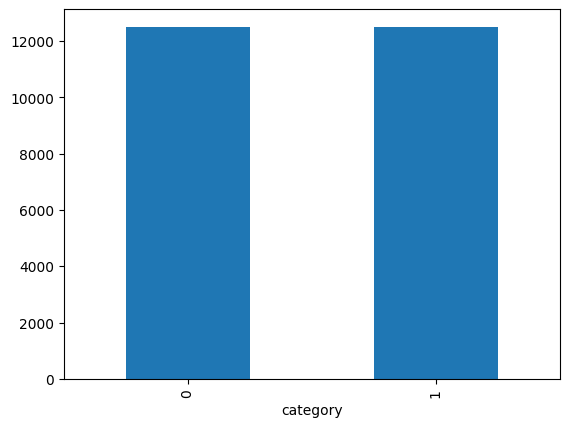

In [7]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

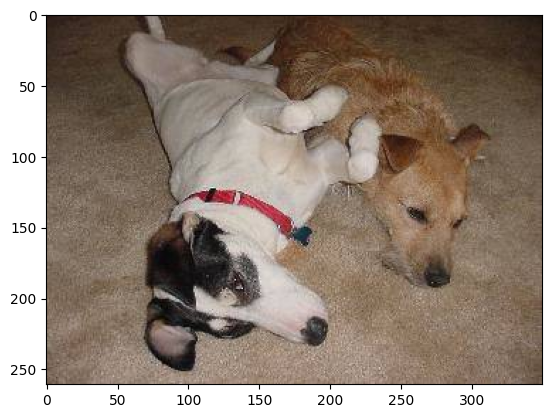

In [8]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Directory path
directory_path = r"C:\Users\Tope\Desktop\Project Code\Datasets\train"

# Get a list of filenames
filenames = os.listdir(directory_path)

# Choose a random filename
sample = random.choice(filenames)

# Load and display the image
image_path = os.path.join(directory_path, sample)
image = Image.open(image_path)
plt.imshow(image)
plt.show()


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience=10)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

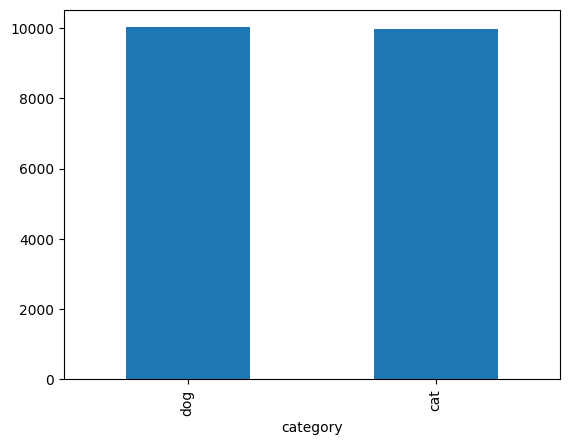

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

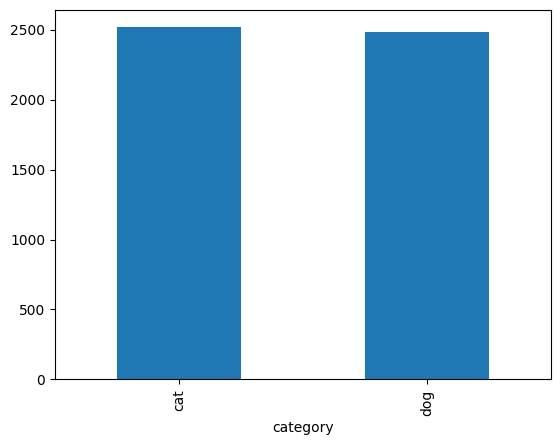

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"C:\Users\Tope\Desktop\Project Code\Datasets\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\Tope\Desktop\Project Code\Datasets\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    r"C:\Users\Tope\Desktop\Project Code\Datasets\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


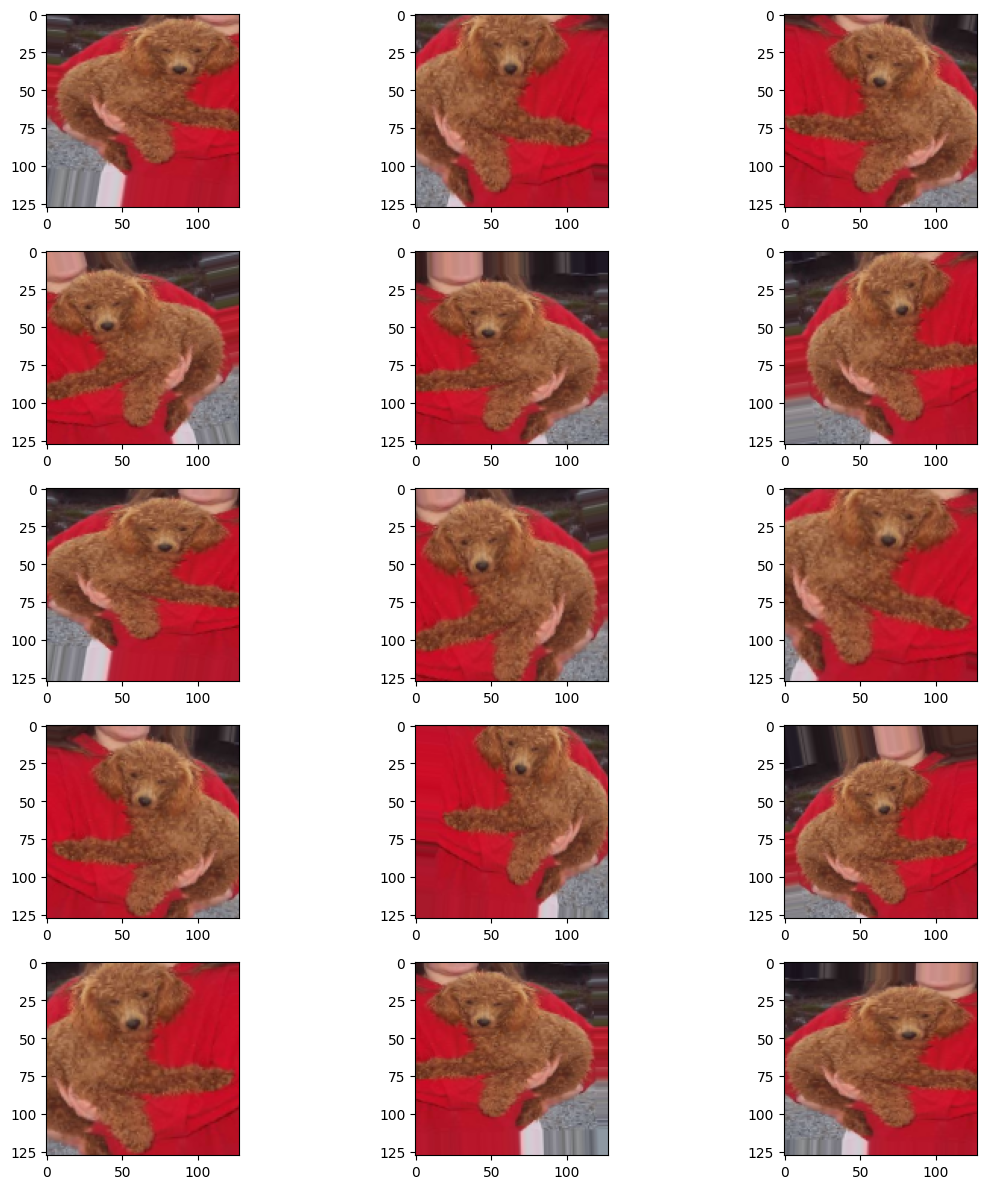

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

# Save Model

In [24]:
model.save_weights("model.h5")

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = os.listdir(r"C:\Users\Tope\Desktop\Project Code\Datasets\test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\Tope\Desktop\Project Code\Datasets\test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\Tope\AppData\Local\Temp\ipykernel_4884\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

<Axes: xlabel='category'>

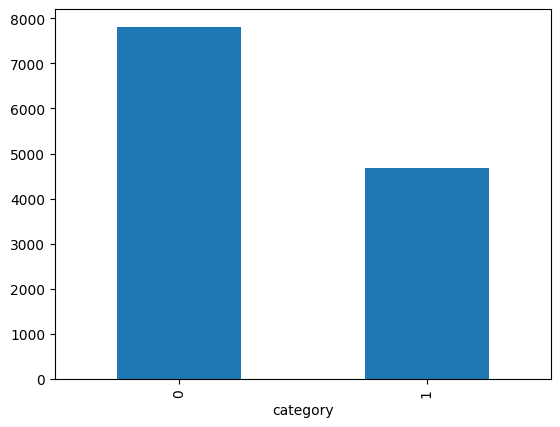

In [34]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\Tope\Desktop\Project Code\Datasets\test1" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

LIME TECHNIQUE

In [ ]:
pip install lime

In [ ]:
import tensorflow as tf
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt

In [ ]:
model = tf.keras.models.load_model(r"C:\Users\Tope\Desktop\Project Code\model.h5")


In [ ]:
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Assuming your model was trained with inputs in [0, 255] range
    return image

In [ ]:
def predict_function(images):
    preprocessed_images = np.array([preprocess_image(image) for image in images])
    predictions = model.predict(preprocessed_images)
    return predictions

In [ ]:
image_path = r"C:\Users\Tope\Desktop\Project Code\Datasets\test1\1.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)

In [ ]:
#Create the Lime Explainer
explainer = LimeImageExplainer()

# Explain the Cnn predictions using lime
num_features = 10
explanation = explainer.explain_instance(image, predict_function, top_labels=1, hide_color=0, num_samples=1000)

In [ ]:
# Get the heatmap from the explanation
heatmap = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)[1]

In [ ]:
# Get the heatmap from the explanation
heatmap = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)[1]

In [ ]:
# Plot the original image and heatmap
plt.figure(figsize=(10, 5))

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(image / 255.0)  # Display the original image
plt.title('Original Image')

In [ ]:
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='viridis', alpha=0.8)  # Display the heatmap
plt.title('Heatmap')

In [ ]:
plt.tight_layout()
plt.show()

SHAP TECHNIQUE

In [ ]:
import shap
import matplotlib.pyplot as plt

In [ ]:
model = tf.keras.models.load_model(r'C:\Users\Tope\Desktop\Project Code\model.h5')

In [ ]:
# Function to preprocess the image for the model
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Assuming your model was trained with inputs in [0, 255] range
    return image

In [ ]:
# Load an example image for explanation
image_path = r'C:\Users\Tope\Desktop\Project Code\Datasets\test1\1.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)


In [ ]:
# Preprocess the image for SHAP
preprocessed_image = preprocess_image(image)


In [ ]:
# Create an explainer using the SHAP DeepExplainer
explainer = shap.DeepExplainer(model, np.expand_dims(preprocessed_image, axis=0))

In [ ]:
# Get SHAP values
shap_values = explainer.shap_values(np.expand_dims(preprocessed_image, axis=0))

In [ ]:
# Plot the original image and SHAP heatmap
plt.figure(figsize=(10, 5))

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(image / 255.0)  # Display the original image
plt.title('Original Image')

In [ ]:
plt.subplot(1, 2, 2)
plt.imshow(np.sum(np.abs(shap_values[0][0]), axis=-1), cmap='viridis', alpha=0.8)  # Display the SHAP heatmap
plt.title('SHAP Heatmap')

In [ ]:
plt.tight_layout()
plt.show()

GRADCAM TECHNIQUE

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
model = tf.keras.models.load_model(r'C:\Users\Tope\Desktop\Project Code\model.h5')

In [ ]:
# Print the summary to find the name of the last convolutional layer
print(model.summary())

In [ ]:

image_path = r'C:\Users\Tope\Desktop\Project Code\Datasets\test1\1.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

In [ ]:
last_conv_layer = model.get_layer('Conv2D')


In [ ]:
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

In [ ]:
# Calculate the gradients of the predicted class with respect to the output feature map
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    predicted_class = np.argmax(predictions)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)[0]

In [ ]:
# Global average pooling of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
# Multiply each channel in the feature map by its corresponding gradient score
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)

In [ ]:
# ReLU thresholding
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [ ]:
# Resize heatmap to match the input image size
heatmap = tf.image.resize(heatmap, (224, 224))

In [ ]:
# Overlay the heatmap on the original image
heatmap = np.array(heatmap)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image[0], 0.5, heatmap, 0.5, 0)


In [ ]:
# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image[0] / 255.0)
plt.title('Original Image')


In [ ]:
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Heatmap')

In [ ]:
plt.subplot(1, 3, 3)
plt.imshow(superimposed_img / 255.0)
plt.title('Superimposed Image')

In [ ]:
plt.tight_layout()
plt.show()